<a href="https://colab.research.google.com/github/Gruz77/Deep-Learning-in-Finance/blob/main/Call_Put_Prediction/Call_Put_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Option Pricing with Deep Learning <center/>
---
---
> Aims: To predict the rescaled mid_price (by the mid_price of the underlying) of market options, based on different predictors.


# Data

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras.layers import LeakyReLU
plt.style.use("ggplot")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv(".../ES_options.csv.gz", index_col=0, parse_dates=True)

In [ ]:
data

,mid,bid,ask,strike,option_type,expiry,days_to_expiry
index,,,,,,,
2009-03-09 15:00:00,673.000,0.05,0.25,1000,call,2009-04-17,39
2009-03-09 15:00:00,673.000,0.15,1.55,1000,call,2009-05-15,67
2009-03-09 15:00:00,673.000,0.50,2.10,1000,call,2009-06-19,102
2009-03-09 15:00:00,673.000,1.70,2.35,1000,call,2009-09-18,193
2009-03-09 15:00:00,673.000,4.00,5.50,1000,call,2009-12-18,284
...,...,...,...,...,...,...,...
2014-09-15 15:00:00,1975.125,1.20,1.65,2375,call,2015-06-19,277
2014-09-15 15:00:00,1975.125,0.85,1.30,2400,call,2015-06-19,277
2014-09-15 15:00:00,1975.125,0.40,0.85,2450,call,2015-06-19,277


## Adding columns

- We will rework the data to : 
  - Add a column of mid option=(ask+bid)/2 of the option price
  - Add a column of the spread (ask-bid) of the option price (spread/mid option)
  - Add columns of values rescaled by the starting price (mid): strike and option price
  - Add columns for the volatility measure measured over a rolling window (rolling(K).std()), e.g. at 7, 14 and 49 days.
  - Add a price forecast column from the Black-Scholes formula
  - Assume that r = 0

In [ ]:
# The rate r is assumed to be 0
data['r'] = 0 

# Add mid_option (variable to be predicted)
data['mid_option'] = (data['ask'] + data['bid'])/2

# k = exp(-rt)*K /S0 where r = 0
data['k'] = data['strike']/data['mid']

# Option spread normalized by S0
data['spread_option_rel'] = (data['ask'] - data['bid'])/data['mid']

# Rescheduled option price
data['mid_option_rel'] = data['mid_option']/data['mid']

# Maturity 
data['T_scaled'] = data['days_to_expiry']/365


# Log price for the calculation of the flight 
# We calculate the log price on a same index (first : we take the first value by index) that we differentiate then
data_log_mid = np.log(pd.DataFrame(data['mid'].groupby('index').first())).diff()
data_log_mid.index = pd.to_datetime(data_log_mid.index)

data["logret"] = data_log_mid
data.dropna(inplace=True) 
data

,mid,bid,ask,strike,option_type,expiry,days_to_expiry,r,mid_option,k,spread_option_rel,mid_option_rel,T_scaled,logret
index,,,,,,,,,,,,,,
2009-03-16 15:00:00,750.375,0.10,1.30,1000,call,2009-04-17,32,0,0.700,1.332667,0.001599,0.000933,0.087671,0.108828
2009-03-16 15:00:00,750.375,0.40,2.05,1000,call,2009-05-15,60,0,1.225,1.332667,0.002199,0.001633,0.164384,0.108828
2009-03-16 15:00:00,750.375,1.75,3.50,1000,call,2009-06-19,95,0,2.625,1.332667,0.002332,0.003498,0.260274,0.108828
2009-03-16 15:00:00,750.375,2.50,4.50,1000,call,2009-07-17,123,0,3.500,1.332667,0.002665,0.004664,0.336986,0.108828
2009-03-16 15:00:00,750.375,7.50,8.50,1000,call,2009-09-18,186,0,8.000,1.332667,0.001333,0.010661,0.509589,0.108828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-15 15:00:00,1975.125,1.20,1.65,2375,call,2015-06-19,277,0,1.425,1.202456,0.000228,0.000721,0.758904,-0.008319
2014-09-15 15:00:00,1975.125,0.85,1.30,2400,call,2015-06-19,277,0,1.075,1.215113,0.000228,0.000544,0.758904,-0.008319
2014-09-15 15:00:00,1975.125,0.40,0.85,2450,call,2015-06-19,277,0,0.625,1.240428,0.000228,0.000316,0.758904,-0.008319


## Addition of 7, 14 and 49 day volatility

In [ ]:
data_log_mid.dropna(inplace=True)

data_log_mid_rol_7 = data_log_mid.rolling(7).std().dropna()
data_log_mid_rol_14 = data_log_mid.rolling(14).std().dropna()
data_log_mid_rol_49 = data_log_mid.rolling(49).std().dropna()

data["logret_vol_7"] = data_log_mid_rol_7
data["logret_vol_14"] = data_log_mid_rol_14
data["logret_vol_49"] = data_log_mid_rol_49

data.dropna(inplace=True)

## Adding price prediction by Black & Scholes formula

- Here we assume that supporting Deep Learning with known financial models can be a good initiative. So we will add to the predictor matrix the option price predicted by the Black & Scholes formula.
  - We take the 49-day volatility, assuming that the more days will give a better estimate of the volatility.
  - Very important: Multiply the volatility by $\sqrt{52}$ because our data is weekly, and the closed BS formula takes into account annual values.

- It is important to compare the results obtained by Black & Scholes price with the mid of the option price (market data). 

- We notice that the BS and market prices are consistent. We can even have an overview of the risk premiums of the banks, with the prices of the options quoted on the market always higher than those given by Black & Scholes.

In [ ]:
%%capture
# call 
def call_euro_BS(S0,K,T,r,sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)* T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (S0*norm.cdf(d1) -K*np.exp(-r*T)*norm.cdf(d2))

# put 
def put_euro_BS(S0,K,T,r,sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)* T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return (-S0*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2))

# For the call 
data_call = data.loc[data.option_type == 'call']
data_call.loc[:,'BS_price'] = call_euro_BS(data_call['mid'],data_call['strike'],data_call['T_scaled'],data_call['r'],np.sqrt(52)*data_call['logret_vol_49'])
data.loc[data.option_type == 'call', "BS_price"] = data_call["BS_price"]

# For the put
data_put = data.loc[data.option_type == 'put']
data_put.loc[:, 'BS_price'] = put_euro_BS(data_put['mid'],data_put['strike'],data_put['T_scaled'],data_put['r'],np.sqrt(52)*data_put['logret_vol_49'])
data.loc[data.option_type == 'put', "BS_price"] = data_put["BS_price"]

data["BS_price_rel"] = data["BS_price"]/data["mid"]

## Final Dataset

In [ ]:
data

,mid,bid,ask,strike,option_type,expiry,days_to_expiry,r,mid_option,k,spread_option_rel,mid_option_rel,T_scaled,logret,logret_vol_7,logret_vol_14,logret_vol_49,BS_price,BS_price_rel
index,,,,,,,,,,,,,,,,,,,
2010-05-31 15:00:00,1090.500,79.75,180.25,1000,call,2010-12-17,200,0,130.000,0.917011,0.092160,0.119211,0.547945,0.016994,0.026540,0.022138,0.037079,135.387104,0.124151
2010-05-31 15:00:00,1090.500,49.00,60.00,1000,put,2010-12-17,200,0,54.500,0.917011,0.010087,0.049977,0.547945,0.016994,0.026540,0.022138,0.037079,44.887104,0.041162
2010-05-31 15:00:00,1090.500,39.75,112.00,1100,call,2010-12-17,200,0,75.875,1.008712,0.066254,0.069578,0.547945,0.016994,0.026540,0.022138,0.037079,81.672347,0.074894
2010-05-31 15:00:00,1090.500,8.00,20.50,1125,call,2010-06-18,18,0,14.250,1.031637,0.011463,0.013067,0.049315,0.016994,0.026540,0.022138,0.037079,12.514163,0.011476
2010-05-31 15:00:00,1090.500,12.75,64.00,1225,call,2010-12-17,200,0,38.375,1.123338,0.046997,0.035190,0.547945,0.016994,0.026540,0.022138,0.037079,39.264450,0.036006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-15 15:00:00,1975.125,1.20,1.65,2375,call,2015-06-19,277,0,1.425,1.202456,0.000228,0.000721,0.758904,-0.008319,0.012881,0.009908,0.012811,0.655205,0.000332
2014-09-15 15:00:00,1975.125,0.85,1.30,2400,call,2015-06-19,277,0,1.075,1.215113,0.000228,0.000544,0.758904,-0.008319,0.012881,0.009908,0.012811,0.447185,0.000226
2014-09-15 15:00:00,1975.125,0.40,0.85,2450,call,2015-06-19,277,0,0.625,1.240428,0.000228,0.000316,0.758904,-0.008319,0.012881,0.009908,0.012811,0.202079,0.000102


# Split $X_{train}$, $Y_{train}$ et $X_{test}$, $Y_{test}$

- We decide to work only on calls for the following parts.
  - Otherwise, we would have to add dummy variables to the predictor matrix to specify whether we are in the case of a call or a put

- We will split our data into train and test, with 20% of the data in test. 
- Our $Y_{train}$ will be the unscaled mid_option (for now)
- We note that for training, the validation set ($10\%$) will be done automatically with the fit of the keras network.

In [ ]:
data_call = data[data.option_type == "call"]

In [ ]:
from sklearn.model_selection import train_test_split

# 80% - 20%
X_train, X_test, Y_train, Y_test = train_test_split(data_call, data_call[["mid_option_rel"]], test_size=0.2, shuffle=True) 

# Dense network $DNN$

- We will use a dense network for our predictions. 

- We keep the same architecture upstream in order to be able to compare predictions according to the different features we will add. 

In [ ]:
def DNN(X):
  DNN = Sequential()

  DNN.add(Dense(150, input_dim=X.shape[1], activation="relu"))
  # ANN.add(LeakyReLU(alpha=0.3))
  DNN.add(Dense(100, activation="relu"))
  # ANN.add(Dropout(rate=0.2))
  DNN.add(Dense(50, activation="relu"))
  # ANN.add(LeakyReLU(alpha=0.3))
  DNN.add(Dense(1, activation="relu"))

  DNN.compile(loss="mse", optimizer="adam", metrics=["mse"]) 

  return DNN

# 1 Incomplete parameters: $DNN_1$

- We try to predict the price with only 2 features:
  - The rescheduled strike 
  - The time to maturity in fraction of a year (basically in days, and divided by 365)

In [ ]:
X_train_1 = X_train[["k", "T_scaled"]]
X_test_1 = X_test[["k", "T_scaled"]]

In [ ]:
DNN_1 = DNN(X_train_1)

In [ ]:
DNN_1.fit(X_train_1, Y_train, batch_size=32, validation_split= 0.1, epochs=30)

In [ ]:
predictions = DNN_1.predict(X_test_1)

## Actual vs. predicted values

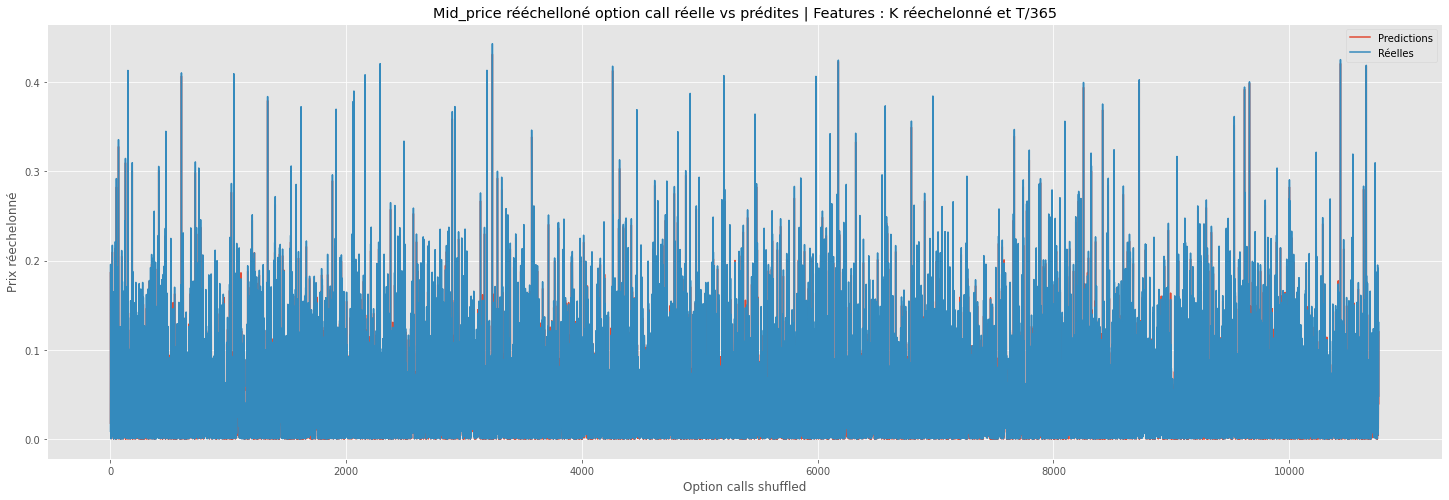

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.set(title="Mid_price rééchelloné option call réelle vs prédites | Features : K réechelonné et T/365", xlabel="Option calls shuffled", ylabel="Prix réechelonné")
ax.plot(predictions, label="Predictions");
ax.plot(Y_test.values, label="Réelles");
ax.legend();

- We see that with only the two predictors :
  - The rescheduled strike $K
  - The rescheduled maturity (time to expiration)
- The network already predicts the rescheduled price very well. 

- Let's now see if adding predictors improves our accuracy even further.

## Metrics : MAE et RMSE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
metrics_1 = pd.DataFrame({"DNN1":[mean_squared_error(predictions, Y_test, squared=True), mean_absolute_error(predictions, Y_test)]}, index=["MAE", "RMSE"])
metrics_1

,DNN1
MAE,0.000080
RMSE,0.005878


- These satisfactory metrics will serve as a basis for comparison in the future.

---
# 2 Incomplete parameters + relative spread: $DNN_2$

- Here we will try to add the bid/ask spread (also relative) to see if it improves our prediction. 

In [ ]:
X_train_2 = X_train[["k", "T_scaled", "spread_option_rel"]]
X_test_2 = X_test[["k", "T_scaled", "spread_option_rel"]]

In [ ]:
DNN_2 = DNN(X_train_2)

In [ ]:
DNN_2 = DNN_2.fit(X_train_2, Y_train, batch_size=32, validation_split= 0.1, epochs=30)

In [ ]:
predictions = DNN_2.model.predict(X_test_2)

## Actual vs. predicted values

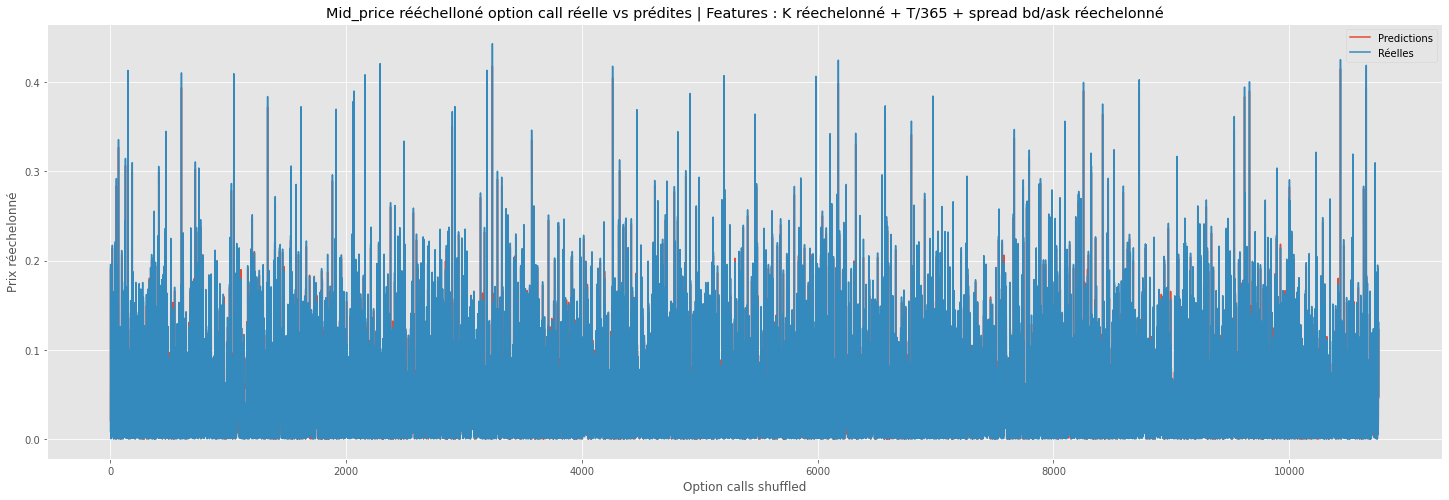

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.set(title="Mid_price rééchelloné option call réelle vs prédites | Features : K réechelonné + T/365 + spread bd/ask réechelonné", xlabel="Option calls shuffled", ylabel="Prix réechelonné")
ax.plot(predictions, label="Predictions");
ax.plot(Y_test.values, label="Réelles");
ax.legend();

## Metrics : MAE et RMSE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
metrics_2 = pd.DataFrame({"DNN2":[mean_squared_error(predictions, Y_test, squared=True), mean_absolute_error(predictions, Y_test)]}, index=["MAE", "RMSE"])
metrics_2

,DNN1
MAE,0.000066
RMSE,0.005490


- We can therefore see that the addition of the relative bid/ask spread has improved our accuracy, in terms of MAE and RMSE. However, the improvement is not incredible.

---
# 3 Incomplete parameters + relative spread + volatility measure: $DNN_3$

- Here we will add the volatility measure that we calculated over $49$ weeks, and see if it improves our prediction.

In [ ]:
X_train_3 = X_train[["k", "T_scaled", "spread_option_rel", "logret_vol_49"]]
X_test_3 = X_test[["k", "T_scaled", "spread_option_rel", "logret_vol_49"]]

In [ ]:
DNN_3 = DNN(X_train_3)

In [ ]:
DNN_3 = DNN_3.fit(X_train_3, Y_train, batch_size=32, validation_split= 0.1, epochs=30)

In [ ]:
predictions = DNN_3.model.predict(X_test_3)

## Actual vs. predicted values

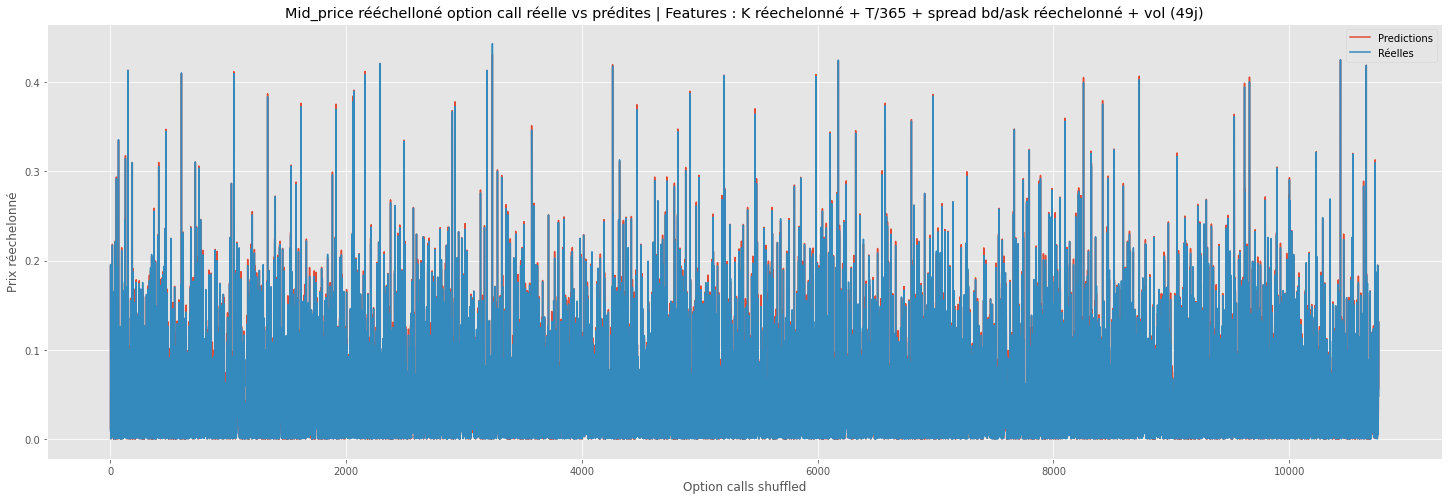

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.set(title="Mid_price rééchelloné option call réelle vs prédites | Features : K réechelonné + T/365 + spread bd/ask réechelonné + vol (49j)", xlabel="Option calls shuffled", ylabel="Prix réechelonné")
ax.plot(predictions, label="Predictions");
ax.plot(Y_test.values, label="Réelles");
ax.legend();

## Metrics : MAE et RMSE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
metrics_3 = pd.DataFrame({"DNN3":[mean_squared_error(predictions, Y_test, squared=True), mean_absolute_error(predictions, Y_test)]}, index=["MAE", "RMSE"])
metrics_3

,DNN3
MAE,0.000023
RMSE,0.003486


- This time we see that the addition of volatility in feature has clearly improved our prediction. We have almost a $2$ factor improvement on the MAE and also on the RMSE.

## Comparison of learning speeds between $DNN_2$ and $DNN_3$.

- Here we will compare the learning speed ($MSE$) of the network we have just trained and the previous one.

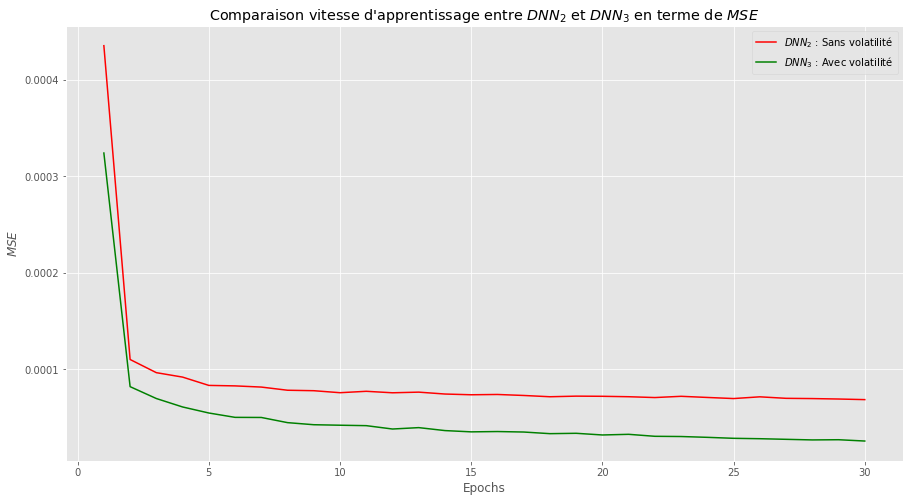

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title="Comparaison vitesse d'apprentissage entre $DNN_2$ et $DNN_3$ en terme de $MSE$", xlabel="Epochs", ylabel="$MSE$")
ax.plot(np.arange(1,len(DNN_2.history["mse"]) + 1), DNN_2.history["mse"], label="$DNN_2$ : Sans volatilité", color="red")
ax.plot(np.arange(1,len(DNN_3.history["mse"]) + 1), DNN_3.history["mse"], label="$DNN_3$ : Avec volatilité", color="green")
ax.legend();

- We see that the learning speed is similar, but the $MSE$ is much lower in the model with the volatility in predictors.

---
# 4 Incomplete parameters + relative spread + volatility measure + price by Black & Scholes

- Here we will add the price obtained by the Black and Scholes formula (rescaled) to see if it improves our prediction. 

In [ ]:
X_train_4 = X_train[["k", "T_scaled", "spread_option_rel", "logret_vol_49", "BS_price_rel"]]
X_test_4 = X_test[["k", "T_scaled", "spread_option_rel", "logret_vol_49", "BS_price_rel"]]

In [ ]:
DNN_4 = DNN(X_train_4)

In [ ]:
DNN_4 = DNN_4.fit(X_train_4, Y_train, batch_size=32, validation_split= 0.1, epochs=30)

In [ ]:
predictions = DNN_4.model.predict(X_test_4)

## Actual vs. predicted values

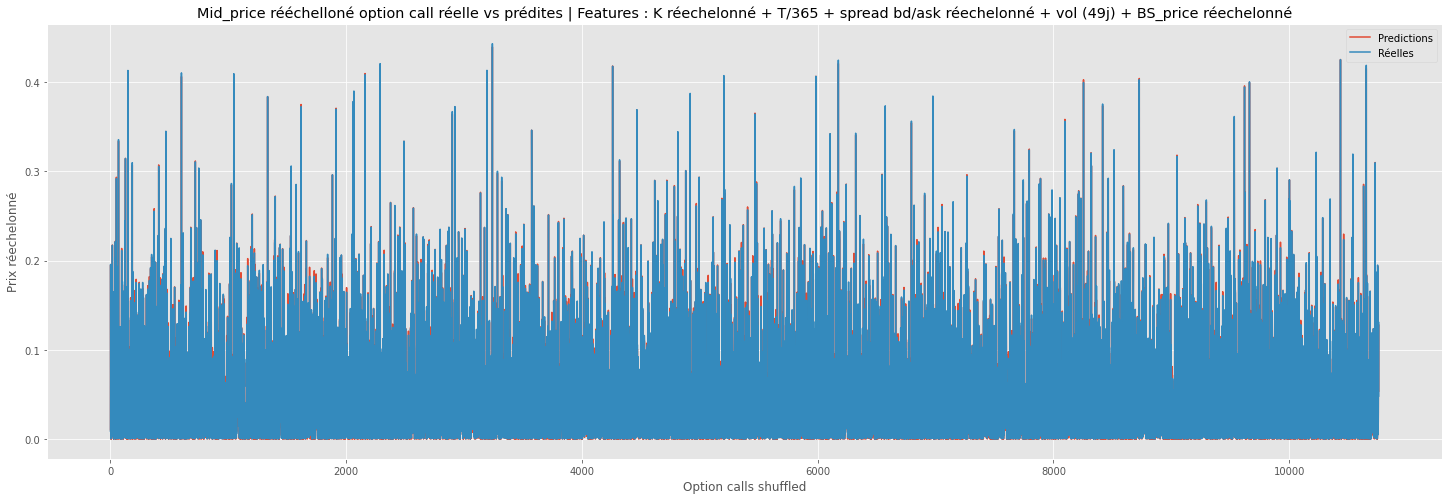

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.set(title="Mid_price rééchelloné option call réelle vs prédites | Features : K réechelonné + T/365 + spread bd/ask réechelonné + vol (49j) + BS_price réechelonné", xlabel="Option calls shuffled", ylabel="Prix réechelonné")
ax.plot(predictions, label="Predictions");
ax.plot(Y_test.values, label="Réelles");
ax.legend();

## Metrics : MAE et RMSE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
metrics_4 = pd.DataFrame({"DNN4":[mean_squared_error(predictions, Y_test, squared=True), mean_absolute_error(predictions, Y_test)]}, index=["MAE", "RMSE"])
metrics_4

,DNN4
MAE,0.000019
RMSE,0.002830


- Once again, we see that adding Black & Scholes prices further improves our prediction. 

- We verify once again that Deep Learning networks "like" to be "helped" by more classical financial models. 

## Comparison of learning speeds between $DNN_2$, $DNN_3$ and $DNN_4$

- Here we will compare the learning speed ($MSE$) of the network we have just trained and the two previous ones.

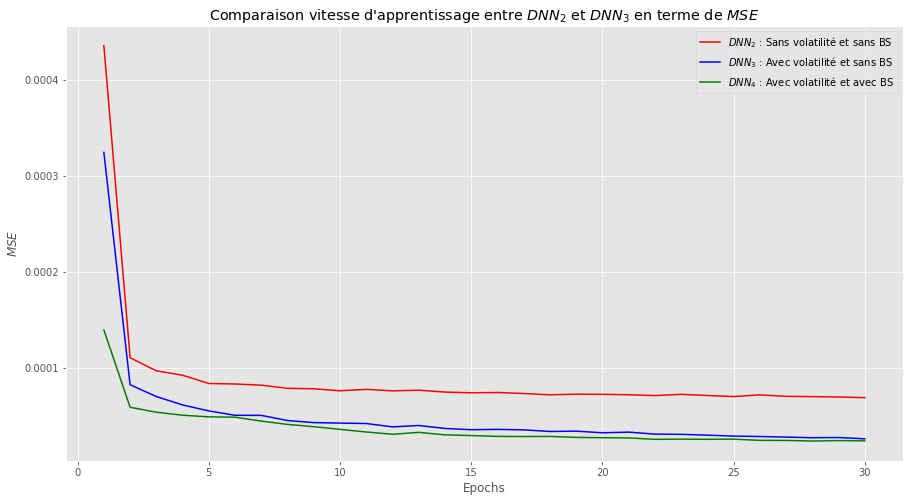

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title="Comparaison vitesse d'apprentissage entre $DNN_2$ et $DNN_3$ en terme de $MSE$", xlabel="Epochs", ylabel="$MSE$")
ax.plot(np.arange(1,len(DNN_2.history["mse"]) + 1), DNN_2.history["mse"], label="$DNN_2$ : Sans volatilité et sans BS", color="red")
ax.plot(np.arange(1,len(DNN_3.history["mse"]) + 1), DNN_3.history["mse"], label="$DNN_3$ : Avec volatilité et sans BS", color="blue")
ax.plot(np.arange(1,len(DNN_4.history["mse"]) + 1), DNN_4.history["mse"], label="$DNN_4$ : Avec volatilité et avec BS", color="green")
ax.legend();

- We verify that the last network is the one with the lowest $MSE$ for each epoch.

- We also see that the improvement is less obvious than for the models without/with volatility.

---
# General comparisons in terms of $MAE$ and $RMSE$.

In [ ]:
comparaison_total = pd.concat([metrics_1, metrics_2, metrics_3, metrics_4], axis=1)
comparaison_total

,DNN1,DNN2,DNN3,DNN4
MAE,0.000080,0.000066,0.000023,0.000019
RMSE,0.005878,0.005490,0.003486,0.002830


- As we can see, the addition of the predictor improved the $MAE$ and $RMSE$ in each case. 

- We also verified with $DNN_4$ that helping DL networks with the results of more classical financial models is a good initiative.